In [1]:
import sys
import os
import pymc as pm
import arviz as az
import numpy as np

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_loader import load_and_process_data
from src.plot_utils import plot_price_history, plot_change_point_result

In [3]:
df = load_and_process_data('../data/raw/BrentOilPrices.csv')
print(f"Data Loaded: {df.shape[0]} rows")
df.head()

c:\Users\Abenezer\Desktop\KAIM Project\brent-oil-dashboard\src\data_loader.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Data Loaded: 9010 rows


,Date,Price,Log_Returns
1,1987-05-21,18.45,-0.009709
2,1987-05-22,18.55,0.005405
3,1987-05-25,18.60,0.002692
4,1987-05-26,18.63,0.001612
5,1987-05-27,18.60,-0.001612


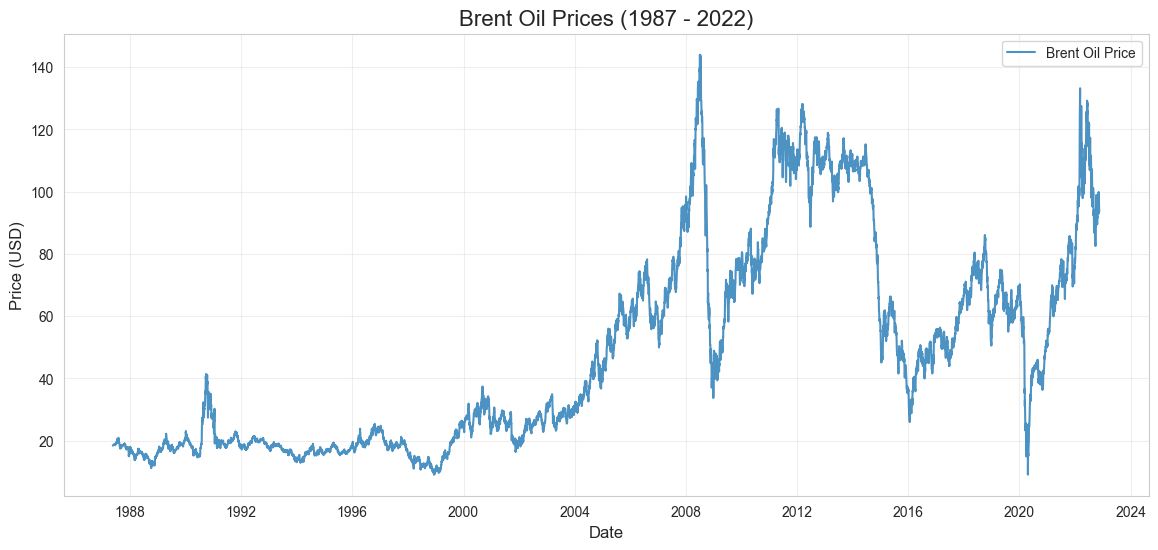

In [4]:
plot_price_history(df)


In [5]:
start_date = '2014-01-01'
end_date = '2015-12-31'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
subset = df.loc[mask].reset_index(drop=True)

prices = subset['Price'].values
dates = subset['Date'].values
print(f"Modeling subset: {len(prices)} days")

Modeling subset: 509 days


In [6]:

with pm.Model() as model:
    # Priors
    mu_1 = pm.Normal("mu_1", mu=prices.mean(), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=prices.mean(), sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Change point (Tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(prices)-1)
    
    # Logic
    idx = np.arange(len(prices))
    mu_switch = pm.math.switch(idx < tau, mu_1, mu_2)
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu_switch, sigma=sigma, observed=prices)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_1, mu_2, sigma]
>Metropolis: [tau]


c:\Users\Abenezer\Desktop\KAIM Project\brent-oil-dashboard\venv11\Lib\site-packages\rich\live.py:260: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 281 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
tau_samples = trace.posterior['tau'].values.flatten()
tau_mean_idx = int(tau_samples.mean())
detected_date = dates[tau_mean_idx]

mu1_val = trace.posterior['mu_1'].mean().item()
mu2_val = trace.posterior['mu_2'].mean().item()

print(f"Detected Change Date: {detected_date}")
print(f"Price Before: ${mu1_val:.2f} | Price After: ${mu2_val:.2f}")

Detected Change Date: 2014-11-13T00:00:00.000000
Price Before: $103.50 | Price After: $54.04


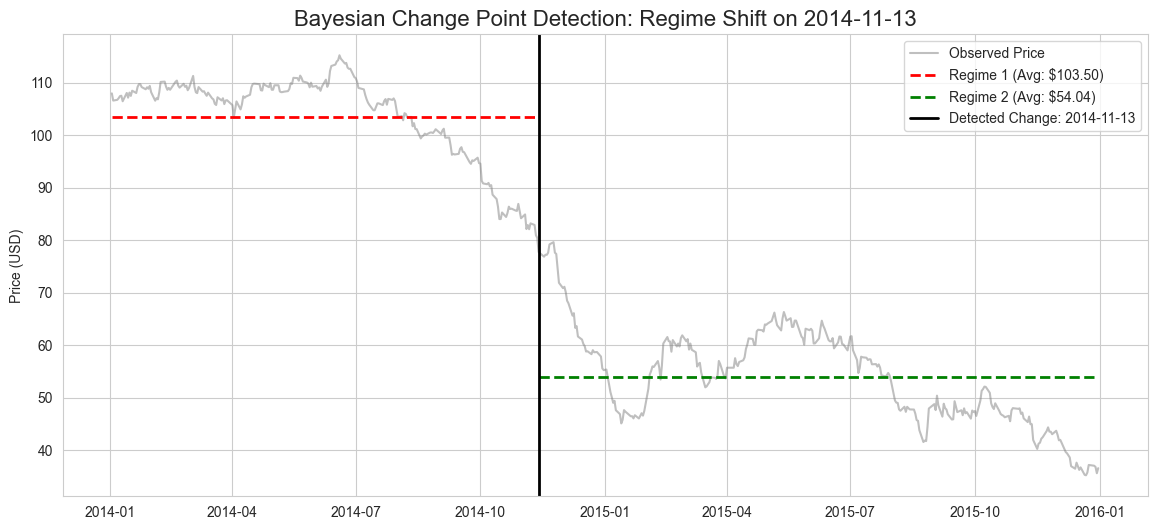

In [8]:
plot_change_point_result(dates, prices, trace, tau_mean_idx, detected_date, mu1_val, mu2_val)